In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import warnings
import joblib
from tqdm import tqdm
import time
import ast
import json

# Sklearn ML
from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Text Processing
import string
import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Lemmatization
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Imbalance learning
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Model Evaluation
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

warnings.filterwarnings('ignore')
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wellswang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/wellswang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/wellswang/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/wellswang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [231]:
# Read the data
prod_df = pd.read_csv('data/prod_df.csv')

**Maunal Dummy Data**

In [173]:
# top_section = ['Womens Everyday Collection', 'Divided Collection', 'Womens Swimwear, beachwear']
top_appearance = ['Solid', 'Melange', 'All over pattern']
top_index = ['Ladieswear', 'Devided']
new_prod_df = prod_df.copy()
# new_prod_df['section_name'] = np.where(new_prod_df['section_name'].isin(top_section), new_prod_df['section_name'], 'Other')
new_prod_df['graphical_appearance_name'] = np.where(new_prod_df['graphical_appearance_name'].isin(top_appearance), new_prod_df['graphical_appearance_name'], 'Other')
new_prod_df['index_group_name'] = np.where(new_prod_df['index_group_name'].isin(top_index), new_prod_df['index_group_name'], 'Other')

**Trousers Only**

In [194]:
new_prod_df = prod_df[prod_df['product_type_name']=='Trousers']

In [82]:
# Custom tokenizer using lemmatizing
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


lemmatizer = WordNetLemmatizer()

ENGLISH_STOP_WORDS = stopwords.words('english')
# Include words we want to clean in stop words
ENGLISH_STOP_WORDS.extend(['none','no', 'nothing','n','a','negative','positive'])

def my_lemma_tokenizer(sentence):
    # # remove punctuation, numbers, and set to lower case
    # sentence = re.sub(r'[^a-zA-Z\s]', '', sentence).lower()

    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    pos_tags = nltk.pos_tag(listofwords)
    listoflemmatized_words = []

    # remove stopwords and any tokens that are just empty strings
    for word, tag in pos_tags:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Lemmatized words

            lemmatized_word = lemmatizer.lemmatize(word,get_wordnet_pos(tag))
            listoflemmatized_words.append(lemmatized_word)

    return listoflemmatized_words

In [83]:
def hm_pipeline(model):
    """
    Create an imbalanced-learn pipeline for text and categorical feature processing,
    applying Synthetic Minority Over-sampling Technique (SMOTE), and a specified model.

    Parameters:
    - model: The classification model to be used in the pipeline.

    Returns:
    - ImbPipeline: An imbalanced-learn pipeline that includes text and categorical feature processing,
      SMOTE for dealing with class imbalance, and the specified classification model.

    Example:
    >>> from sklearn.ensemble import RandomForestClassifier
    >>> from imblearn.pipeline import Pipeline as ImbPipeline
    >>> model = RandomForestClassifier()
    >>> pipeline = hm_pipeline(model)
    >>> pipeline.fit(X_train, y_train)
    >>> y_pred = pipeline.predict(X_test)
    """

    # List of estimators in the pipeline
    estimators = [
        ('smote', SMOTE(random_state=123)),
        ('clf', model)
        ]

    # Create and return the imbalanced-learn pipeline
    return ImbPipeline(estimators)

In [218]:
# Column Tranasformer
# Columns for one-hot encoding
categorical_columns = ['product_type_name', 'product_group_name', 'index_group_name', 'section_name', 'graphical_appearance_name']
# categorical_columns = ['product_type_name', 'section_name', 'graphical_appearance_name', 'product_group_name']


# Create the column transformations list + columns to which to apply
col_transforms = [
    ('desc', CountVectorizer(max_features=200, min_df=10, tokenizer=my_lemma_tokenizer, ngram_range=(1, 2)), 'detail_desc'),
    ('name', CountVectorizer(max_features=200, min_df=10, tokenizer=my_lemma_tokenizer, ngram_range=(1, 2)), 'prod_name'),
    ('normalise', StandardScaler(), ['unit_price']),
    ('cat', OneHotEncoder(drop='first'), categorical_columns)
]

# Create the column transformer
# col_trans = ColumnTransformer(col_transforms, remainder='passthrough')
col_trans = ColumnTransformer(col_transforms)

In [232]:
# Spliting features X and target y
X = prod_df.drop(['trending', 'product_id'], axis=1)
y = prod_df['trending']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)
print(X_train.shape, X_test.shape)

# Coltrans
X_train_transformed = col_trans.fit_transform(X_train)
X_test_transformed = col_trans.transform(X_test)

X_train = X_train_transformed.toarray()
X_test = X_test_transformed.toarray()
y_train = np.array(y_train)
y_test = np.array(y_test)

X_train.shape, X_test.shape

(28962, 8) (7241, 8)


((28962, 124), (7241, 124))

In [233]:
X_train_df = pd.DataFrame(columns = col_trans.get_feature_names_out(), data=X_train)
X_test_df = pd.DataFrame(columns = col_trans.get_feature_names_out(), data=X_test)


# Display the shapes of DataFrames
print("X_train_df shape:", X_train_df.shape)
print("X_test_df shape:", X_test_df.shape)

X_train_df shape: (28962, 124)
X_test_df shape: (7241, 124)


In [164]:
# Specify the model for the pipeline
model_name = 'XGBoost'
model_params = {'objective':'binary:logistic',
                'learning_rate': 0.01,
                'n_estimators': 50,
                'random_state':123}
model = XGBClassifier(**model_params)

# Instantiate pipeline with our custom function
pipe = hm_pipeline(model)
pipe.fit(X_train, y_train)

# Predicting with test data
y_pred = pipe.predict(X_test)
# Print classification report
from sklearn.metrics import classification_report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

       False       0.95      0.79      0.87      6475
        True       0.27      0.65      0.38       766

    accuracy                           0.78      7241
   macro avg       0.61      0.72      0.62      7241
weighted avg       0.88      0.78      0.81      7241



In [28]:
prod_df.columns

Index(['product_id', 'prod_name', 'detail_desc', 'product_type_name',
       'product_group_name', 'index_group_name', 'section_name',
       'graphical_appearance_name', 'unit_price', 'trending'],
      dtype='object')

In [22]:
prod_df.shape

(36203, 10)

In [32]:
data =  prod_df.loc[56].to_frame().transpose()
data_transformed = col_trans.transform(data)
pipe.predict_proba(data_transformed)

array([[0.5734696 , 0.42653042]], dtype=float32)

In [33]:
data

,product_id,prod_name,detail_desc,product_type_name,product_group_name,index_group_name,section_name,graphical_appearance_name,unit_price,trending
56,534795,DOMINIC,"Top in cotton jersey with long sleeves, an ope...",Sweater,Garment Upper body,Menswear,Contemporary Smart,Placement print,0.010153,False


**Model Training**

In [234]:
# Specify the model for the pipeline
model_name = 'XGBoost'
model_params = {'objective':'binary:logistic',
                'learning_rate': 0.01,
                'n_estimators': 100,
                'random_state':123}
model = XGBClassifier(**model_params)

# Instantiate pipeline with our custom function
pipe = hm_pipeline(model)
pipe.fit(X_train, y_train)

# Predicting with test data
y_pred = pipe.predict(X_test)
# Print classification report
from sklearn.metrics import classification_report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

       False       0.96      0.81      0.88      6475
        True       0.30      0.70      0.42       766

    accuracy                           0.79      7241
   macro avg       0.63      0.75      0.65      7241
weighted avg       0.89      0.79      0.83      7241



# Shapely values

In [116]:
import shap
shap.initjs()

Choosing a single data point

In [268]:
n=14
data = new_prod_df.reset_index().loc[n].to_frame().transpose()
display(data)
input = col_trans.transform(data)
input = pd.DataFrame(columns = col_trans.get_feature_names_out(), data=input.todense())
print(f'Trending: {data["trending"].values}')

,index,product_id,prod_name,detail_desc,product_type_name,product_group_name,index_group_name,section_name,graphical_appearance_name,unit_price,trending
14,69,665477,Mini Flare H.W Bronx,"5-pocket, slim-fit jeans in stretch denim with...",Trousers,Garment Lower body,Divided,Ladies Denim,Denim,0.033881,True


Trending: [True]


In [269]:
pipe.predict_proba(input)
# pipe.predict(input)

array([[0.41163296, 0.58836704]], dtype=float32)

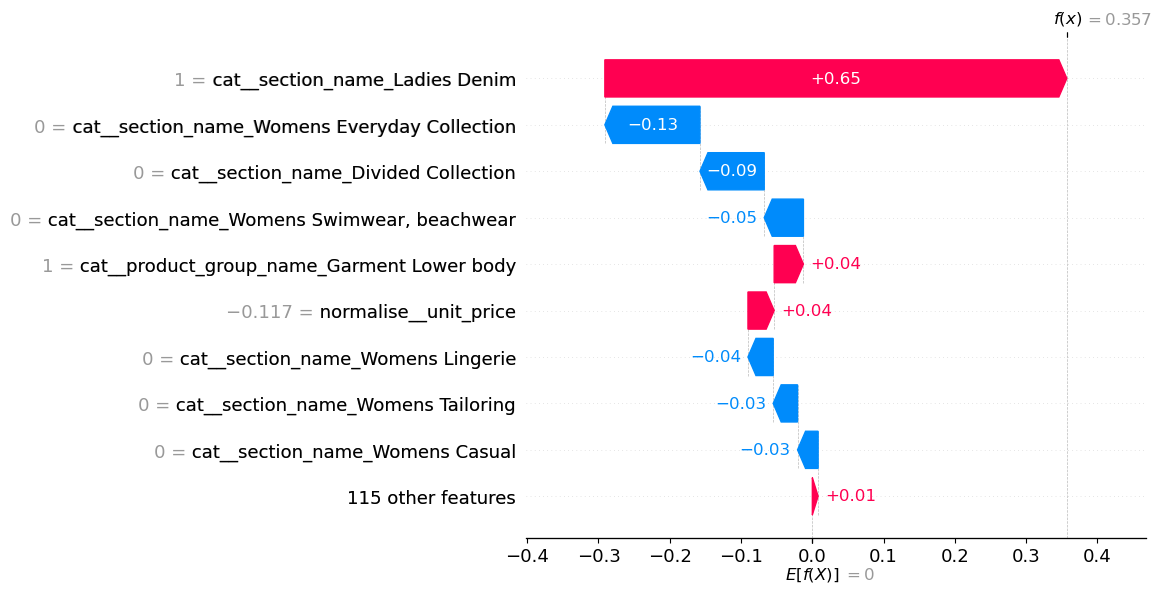

In [270]:
# Fit tree-specific kernel for SHAP
explainer = shap.Explainer(pipe.named_steps['clf'])

# Obtain SHAP values
shap_values = explainer(input)
# Create a waterfall plot using shap.plots.waterfall
plt.figure()
shap.plots.waterfall(shap_values[0], max_display=10)

# Plotting Sales

In [263]:
hm_sales = pd.read_csv('data/hm_sales.csv')
hm_sales.shape

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
hm_sales.product_type_name.unique()

In [245]:
types = ['Bra', 'Vest top', 'Trousers']

hm_sales_filtered = hm_sales[hm_sales['product_type_name'].isin(types)]

In [246]:
hm_sales_filtered.shape

(6221288, 26)

In [22]:
hm_sales_filtered.to_csv('hm_sales_filtered.csv', index=False)

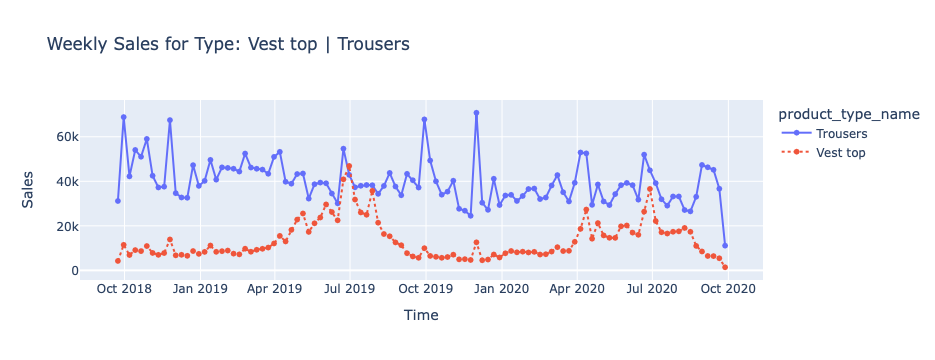

In [248]:
# Comparing sales of different sections
def compare_type_weekly_sales(types):
    # filter df
    df = hm_sales[hm_sales['product_type_name'].isin(types)]
    # timeseries prep
    df['t_dat']=pd.to_datetime(df['t_dat'])
    df = df.set_index('t_dat')
    df = df.groupby('product_type_name')['units'].resample('W').sum().reset_index()

    # Create line plot with two categories
    fig = px.line(df, x='t_dat', y='units', color='product_type_name', markers=True, line_dash='product_type_name',
              labels={'t_dat': 'Time', 'units': 'Sales'},
              title='Weekly Sales for Type: ' +' | '.join([f"{i}" for i in types]))
    fig.show()

types = ['Vest top', 'Trousers']
compare_type_weekly_sales(types)


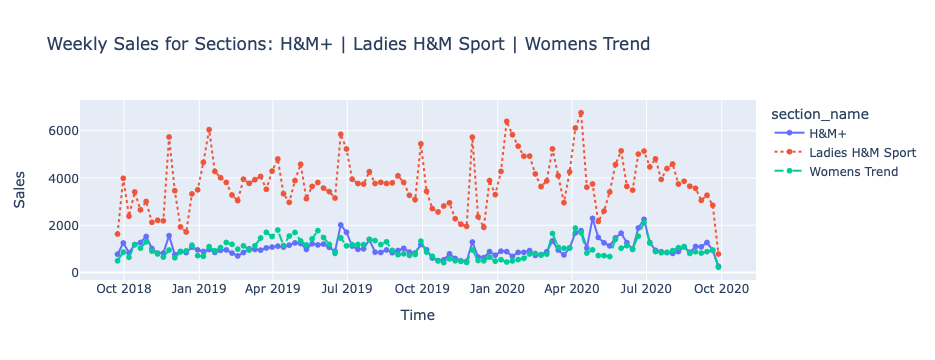

In [251]:
# Comparing sales of different sections
def compare_section_weekly_sales(df, sections):
    # filter df
    df = df[df['section_name'].isin(sections)]
    # timeseries prep
    df['t_dat']=pd.to_datetime(df['t_dat'])
    df = df.set_index('t_dat')
    df = df.groupby('section_name')['units'].resample('W').sum().reset_index()

    # Create line plot with two categories
    fig = px.line(df, x='t_dat', y='units', color='section_name', markers=True, line_dash='section_name',
              labels={'t_dat': 'Time', 'units': 'Sales'},
              title='Weekly Sales for Sections: ' +' | '.join([f"{i}" for i in sections]))
    return fig

sections = ['H&M+', 'Ladies H&M Sport', 'Womens Trend']
fig = compare_section_weekly_sales(hm_sales_filtered, sections)
fig.show()